# Carbonate system through SeaCURE system 

Note to Paul. To make this work on binder, you need the the runtime.txt, apt.txt and requirements.txt associated with github commit 6088dd44f2e69c62eeda9b6b555c8174773ac4b0 in https://github.com/PaulHalloran/Jupiter_notebooks_halloran . These install graphviz via apt, then graphviz, pandas, PyCO2SYS and numpy with pip. Note at present does not work if conda installs are invoked with an environment.yml file.

### functions required for subsequent calculations

In [1]:
import numpy as np
import PyCO2SYS as pyco2
import pandas as pd
from graphviz import Digraph

def carbon_chem_from_alk_and_dic(alkalinity, dic, temperature, salinity):
    # * **Total alkalinity** (type `1`) in μmol·kg<sup>−1</sup>.
    # * **Dissolved inorganic carbon** (type `2`) in μmol·kg<sup>−1</sup>.
    # * **pH** (type `3`) on the Total, Seawater, Free or NBS scale[^1].  Which scale is given by the input `pHSCALEIN`.
    # * **Partial pressure** (type `4`) or **fugacity** (type `5`) **of CO<sub>2</sub>** in μatm or **aqueous CO<sub>2</sub>** (type `8`) in μmol·kg<sup>−1</sup>.
    # * **Carbonate ion** (type `6`) in μmol·kg<sup>−1</sup>.
    # * **Bicarbonate ion** (type `7`) in μmol·kg<sup>−1</sup>.
    # Define input conditions
    kwargs_alk_dic = dict(
        par1 = alkalinity,  # Value of the first parameter
        par2 = dic,  # Value of the second parameter, which is a long vector of different DIC's!
        par1_type = 1,  # The first parameter supplied is of type "1", which is "alkalinity"
        par2_type = 2,  # The second parameter supplied is of type "2", which is "DIC"
        salinity = salinity,  # Salinity of the sample
        temperature = temperature,  # Temperature at input conditions
    )
    return pd.DataFrame.from_dict(pyco2.sys(**kwargs_alk_dic), orient='index').T

def carbon_chem_from_pH_and_dic(pH, dic, temperature, salinity):
    # Define input conditions
    kwargs_pH_dic = dict(
        par1 = dic,  # Value of the first parameter
        par2 = pH,  # Value of the second parameter, which is a long vector of different DIC's!
        par1_type = 2,  # The first parameter supplied is of type "1", which is "alkalinity"
        par2_type = 3,  # The second parameter supplied is of type "2", which is "DIC"
        salinity = salinity,  # Salinity of the sample
        temperature = temperature,  # Temperature at input conditions
    )
    return pd.DataFrame.from_dict(pyco2.sys(**kwargs_pH_dic), orient='index').T

def conservative_mixing(conc1,conc2,fraction_conc1):
    return (conc1 * fraction_conc1) + (conc2 * (1.0 - fraction_conc1))


def itterate_on_pH(co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph,seawater_temperature, seawater_salinity,increment,direction):
    counter = 0
    if direction == 'down':
        while co2_stripper_predicted_ph > pH_in_seawater_co2_stripper:
            initial_pH_estimate -= increment
            counter += 1
            ED_cell_seawater = carbon_chem_from_pH_and_dic(initial_pH_estimate, inflow_seawater['dic'].values, seawater_temperature, seawater_salinity)
            alkalinity_after_mixing_streams = conservative_mixing(ED_cell_seawater['alkalinity'].values,inflow_seawater['alkalinity'].values,fraction_of_water_passing_through_ED_acid_stream)
            co2_stripper_conditions = carbon_chem_from_alk_and_dic(alkalinity_after_mixing_streams, inflow_seawater_dissolved_inorganic_carbon, seawater_temperature, seawater_salinity)
            co2_stripper_predicted_ph = co2_stripper_conditions['pH'].values
            if counter > 10000:
                print('max iterations hit')
                break
    else:
        while co2_stripper_predicted_ph < pH_in_seawater_co2_stripper:
            initial_pH_estimate += increment
            counter += 1
            ED_cell_seawater = carbon_chem_from_pH_and_dic(initial_pH_estimate, inflow_seawater['dic'].values, seawater_temperature, seawater_salinity)
            alkalinity_after_mixing_streams = conservative_mixing(ED_cell_seawater['alkalinity'].values,inflow_seawater['alkalinity'].values,fraction_of_water_passing_through_ED_acid_stream)
            co2_stripper_conditions = carbon_chem_from_alk_and_dic(alkalinity_after_mixing_streams, inflow_seawater_dissolved_inorganic_carbon, seawater_temperature, seawater_salinity)
            co2_stripper_predicted_ph = co2_stripper_conditions['pH'].values
            if counter > 10000:
                print('max iterations hit')
                break
    return ED_cell_seawater,co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph

### Define inputs

In [2]:
seawater_temperature = 10.0 # degrees C
seawater_salinity = 35.0 # psu
inflow_seawater_alkalinity = 2300.0 # µeq/kg
inflow_seawater_dissolved_inorganic_carbon = 2100.0 # µmol/kg
fraction_of_water_passing_through_ED_acid_stream = 0.1 # decimal fraction of the incoming seawater stream diverted through the ED unit
pH_in_seawater_co2_stripper = 4.0
fraction_of_possible_co2_extracted_to_gas_stream = 1.0 # fraction of the available CO2 removed from teh seawater in the sewater Co2 stripper
fraction_of_water_passing_through_ED_base_stream = fraction_of_water_passing_through_ED_acid_stream # initial assumption is that the same volume of fluid is passing through the ED cell's base stream as through the acid stream
fraction_of_co2_depleted_water_in_final_outflow = 0.25 # i.e. how much unpricessed seawater if being mixed with the processed water when returned back to the ocean

Note, initial output variables are:

- pH - self explanatory
- dic - dissolved inorganic carbon concentration. i.e. total amount of dissolved carbon in the seawater in µmol/kg
- alkalinity - total alkalinity, 'the molar amount of bases in a solution that can be converted to uncharged species by a strong acid' ([wikipedia](https://en.wikipedia.org/wiki/Alkalinity#cite_note-2)), µeq/kg
- bicarbonate - concentration of bicarbonate ions µmol/kg
- carbonate - concentration of carbonate ions µmol/kg
- pCO2 - partial presure of CO2, µatm

### Chemistry of inflow seawater


In [3]:
inflow_seawater = carbon_chem_from_alk_and_dic(inflow_seawater_alkalinity, inflow_seawater_dissolved_inorganic_carbon, seawater_temperature, seawater_salinity)
inflow_seawater[['pH','dic','alkalinity','bicarbonate', 'carbonate','pCO2']]


,pH,dic,alkalinity,bicarbonate,carbonate,pCO2
0,8.091704847930695,2100.0,2300.0,1940.980368,143.206398,361.773084


### Conditions in acid stream of ED cell

Crude itteration to find pH in ED cell consistent with the required seawater CO2 stripper pH and fraction of seawaterpassed trhough ED cell

In [4]:
counter = 0
co2_stripper_predicted_ph = 1000.0
initial_pH_estimate = pH_in_seawater_co2_stripper
co2_stripper_conditions = 0.0

ED_cell_seawater,co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph = itterate_on_pH(co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph,seawater_temperature, seawater_salinity,0.1,'down')
ED_cell_seawater,co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph = itterate_on_pH(co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph,seawater_temperature, seawater_salinity,0.01,'up')
ED_cell_seawater,co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph = itterate_on_pH(co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph,seawater_temperature, seawater_salinity,0.001,'down')
ED_cell_seawater,co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph = itterate_on_pH(co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph,seawater_temperature, seawater_salinity,0.0001,'up')
ED_cell_seawater,co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph = itterate_on_pH(co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph,seawater_temperature, seawater_salinity,0.00001,'down')
ED_cell_seawater,co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph = itterate_on_pH(co2_stripper_conditions,initial_pH_estimate,co2_stripper_predicted_ph,seawater_temperature, seawater_salinity,0.000001,'up')

ED_cell_seawater[['pH','dic','alkalinity','bicarbonate', 'carbonate','pCO2']]


,pH,dic,alkalinity,bicarbonate,carbonate,pCO2
0,1.662965999999998,2100.0,-21511.534919,0.096042,0.0,48041.328496


### Conditions in seawater CO2 stripper

In [5]:
co2_stripper_conditions[['pH','dic','alkalinity','bicarbonate', 'carbonate','pCO2']]

,pH,dic,alkalinity,bicarbonate,carbonate,pCO2
0,4.000006046230498,2100.0,-81.153492,20.664562,0.000123,47570.761768


### Fraction of dissolved carbon potentially liberated

In [6]:
fraction_of_liberated_dic = (inflow_seawater_dissolved_inorganic_carbon - co2_stripper_conditions['bicarbonate'].values - co2_stripper_conditions['carbonate'].values)/inflow_seawater_dissolved_inorganic_carbon
print(fraction_of_liberated_dic)

[0.9901596738254074]


### Fraction of dissolved carbon liberated given specified extraction efficiency (fraction_of_possible_co2_extracted_to_gas_stream)


In [7]:
print(fraction_of_liberated_dic * fraction_of_possible_co2_extracted_to_gas_stream)

[0.9901596738254074]


### Conditions in base stream of ED cell


In [8]:
remaining_dic = (co2_stripper_conditions['dic'].values * (1.0 - fraction_of_liberated_dic)) * (1.0/fraction_of_possible_co2_extracted_to_gas_stream)

ED_cell_base_seawater = carbon_chem_from_alk_and_dic(inflow_seawater_alkalinity - ED_cell_seawater['alkalinity'], remaining_dic, seawater_temperature, seawater_salinity)
ED_cell_base_seawater[['pH','dic','alkalinity','bicarbonate', 'carbonate','pCO2']]

,pH,dic,alkalinity,bicarbonate,carbonate,pCO2
0,12.210527851437211,20.664685,23811.534919,0.021282,20.643403,0.0


### Conditions after mixing base stream of ED cell with water from seawater CO2 stripper


In [9]:
alkalinity_after_ED_base_and_stripper_mixing = conservative_mixing(ED_cell_base_seawater['alkalinity'].values,co2_stripper_conditions['alkalinity'].values,fraction_of_water_passing_through_ED_base_stream)
after_ED_base_and_stripper_mixing = carbon_chem_from_alk_and_dic(alkalinity_after_ED_base_and_stripper_mixing, remaining_dic, seawater_temperature, seawater_salinity)
after_ED_base_and_stripper_mixing[['pH','dic','alkalinity','bicarbonate', 'carbonate','pCO2']]

,pH,dic,alkalinity,bicarbonate,carbonate,pCO2
0,11.110095387236399,20.664685,2308.115349,0.265028,20.399655,0.000047


### Conditions after mixing CO2 depleted water with natural seawater in final outflow

In [10]:
alkalinity_in_outflow = conservative_mixing(alkalinity_after_ED_base_and_stripper_mixing,inflow_seawater_alkalinity,fraction_of_co2_depleted_water_in_final_outflow)
dic_in_outflow = conservative_mixing(remaining_dic,inflow_seawater_dissolved_inorganic_carbon,fraction_of_co2_depleted_water_in_final_outflow)

after_ED_base_and_stripper_mixing_with_natural_seawater = carbon_chem_from_alk_and_dic(alkalinity_in_outflow, dic_in_outflow, seawater_temperature, seawater_salinity)
after_ED_base_and_stripper_mixing_with_natural_seawater[['pH','dic','alkalinity','bicarbonate', 'carbonate','pCO2']]

,pH,dic,alkalinity,bicarbonate,carbonate,pCO2
0,8.86868693539054,1580.166171,2302.028837,1095.167031,483.508071,34.112487


## Diagram of results

edit the value in red below to plot up the values for different variables, options include (amongst others):
- 'pH'
- 'dic'
- 'alkalinity'
- 'bicarbonate'
- 'carbonate'
- 'pCO2'

In [11]:
var_to_plot = 'pH'


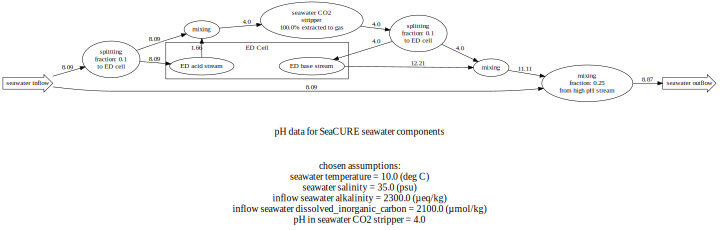

In [14]:
seawater_inflow_value = str(np.around(float(inflow_seawater[var_to_plot].values), decimals=2))
ED_cell_seawater_value = str(np.around(float(ED_cell_seawater[var_to_plot].values), decimals=2))
co2_stripper_value = str(np.around(float(co2_stripper_conditions[var_to_plot].values), decimals=2))
ED_cell_base_seawater_value = str(np.around(float(ED_cell_base_seawater[var_to_plot].values), decimals=2))
after_ED_base_and_stripper_mixing_value = str(np.around(float(after_ED_base_and_stripper_mixing[var_to_plot].values), decimals=2))
after_ED_base_and_stripper_mixing_with_natural_seawater_value = str(np.around(float(after_ED_base_and_stripper_mixing_with_natural_seawater[var_to_plot].values), decimals=2))

from graphviz import Digraph

f=Digraph(name='parent')
cluster_ed_cell = Digraph(name='ed_cell')
# mixing = Digraph(name='mixing')
end  = Digraph(name='end')


f.attr(rankdir='LR', size='10,10')

f.attr('node', shape='oval')
end.attr('node', shape='rarrow')

end.edge('seawater inflow', 'splitting streams 1', label=seawater_inflow_value)

f.node('splitting streams 1',label='splitting\nfraction: '+str(fraction_of_water_passing_through_ED_acid_stream)+'\nto ED cell')
f.node('mixing streams 1',label='mixing')
f.node('mixing streams 2',label='mixing')
f.node('mixing streams 3',label='mixing\nfraction: '+str(fraction_of_co2_depleted_water_in_final_outflow)+'\nfrom high pH stream')

f.node('splitting streams 2',label='splitting\nfraction: '+str(fraction_of_water_passing_through_ED_base_stream)+'\nto ED cell')

f.node('seawater CO2\nstripper', label='seawater CO2\nstripper\n'+str(fraction_of_possible_co2_extracted_to_gas_stream*100.0)+'% extracted to gas')

fraction_of_possible_co2_extracted_to_gas_stream

f.edge('splitting streams 1', 'ED acid stream', label=seawater_inflow_value)
f.edge('splitting streams 1', 'mixing streams 1', label=seawater_inflow_value)
f.edge('mixing streams 1', 'seawater CO2\nstripper', label=co2_stripper_value)
f.edge('ED acid stream', 'mixing streams 1', label=ED_cell_seawater_value)
f.edge('seawater CO2\nstripper', 'splitting streams 2', label=co2_stripper_value)
f.edge('ED base stream', 'mixing streams 2', label=ED_cell_base_seawater_value)
f.edge('splitting streams 2', 'ED base stream', label=co2_stripper_value)
f.edge('splitting streams 2', 'mixing streams 2', label=co2_stripper_value)
f.edge('mixing streams 2', 'mixing streams 3', label=after_ED_base_and_stripper_mixing_value)
end.edge('seawater inflow', 'mixing streams 3', label=seawater_inflow_value)

end.edge('mixing streams 3', 'seawater outflow', label=after_ED_base_and_stripper_mixing_with_natural_seawater_value,shape='rarrow')

# cluster_ed_cell.edge('ED acid stream', 'ED base stream')
with f.subgraph(name='cluster_ed_cell') as cluster_ed_cell:
    cluster_ed_cell.attr(color='black')
    cluster_ed_cell.edge_attr['color'] = 'none'
    cluster_ed_cell.edges([('ED acid stream', 'ED base stream')])
    cluster_ed_cell.attr(label='ED Cell')
    
f.subgraph(end)

f.attr(label=r"""\n\n"""+var_to_plot+""" data for SeaCURE seawater components\n\n
chosen assumptions:
seawater temperature = """+str(seawater_temperature)+""" (deg C)""" """
seawater salinity = """+str(seawater_salinity)+""" (psu)""" """
inflow seawater alkalinity = """+str(inflow_seawater_alkalinity)+""" (µeq/kg)""" """
inflow seawater dissolved_inorganic_carbon = """+str(inflow_seawater_dissolved_inorganic_carbon)+""" (µmol/kg)""" """ 
pH in seawater CO2 stripper = """+str(pH_in_seawater_co2_stripper)+""" """)


f.attr(fontsize='20')

f